In [118]:
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 280)
pd.set_option("display.max_columns", 100)
import json
import emoji
import re
import seaborn as sns
import datetime
#!pip install folium
import folium
import warnings
warnings.filterwarnings('ignore')

In [110]:
# Functions from class and for ploting
from source.twarc_hashtags_and_emojis import *
from source.plots_functions import *
from source.time_utils import *

### Exercise 1. 
Using the full activity file of your politicians, obtain the most popular hashtags and present the top 10 in a bar plot using python.

In [111]:
# Loading the data

# 2020
my_path = "files"

converter = DataFrameConverter()
data = []
with open(my_path+"/politicians1.json") as f:
    for line in f:
        data.append(json.loads(line))
df_20 = converter.process(data)


# 2019
my_path = "files"

converter = DataFrameConverter()
data = []
with open(my_path+"/politicians2.json") as f:
    for line in f:
        data.append(json.loads(line))
df_19 = converter.process(data)

print('2020:', df_20.shape)
print('2019:', df_19.shape)

2020: (8464, 74)
2019: (5542, 74)


In [18]:
# Using the generator to create a new dataframe of hashtags, then convert every string to lowercase and counting each tweet
# 2020
hashtags_20 = pd.DataFrame(list(hash_retrieve(df_20)), columns=['hashtag', 'id'])
hashtags_20["hashtag"] = hashtags_20["hashtag"].str.lower() 
top10_20 = hashtags_20['hashtag'].value_counts()[:10].to_frame().reset_index()

# 2019
hashtags_19 = pd.DataFrame(list(hash_retrieve(df_19)), columns=['hashtag', 'id'])
hashtags_19["hashtag"] = hashtags_19["hashtag"].str.lower()
top10_19 = hashtags_19['hashtag'].value_counts()[:10].to_frame().reset_index()

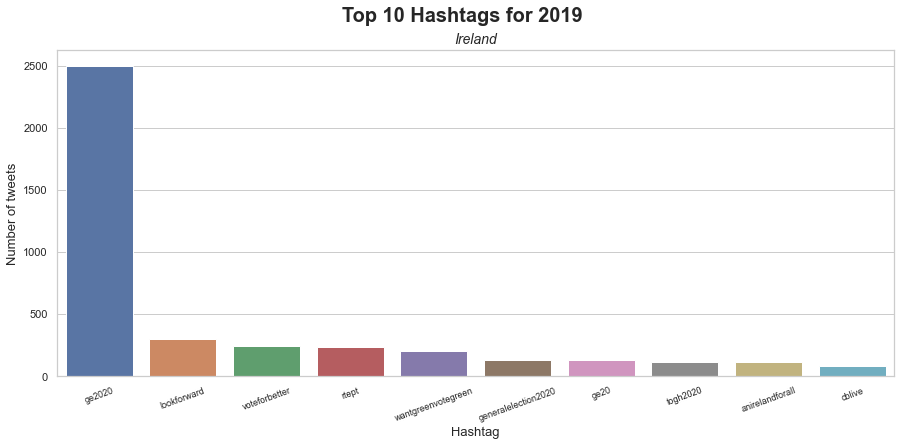

In [20]:
# Plot for 2020
bar_plots("index", "hashtag", top10_20, "Ireland", "Top 10 Hashtags for 2020", "Hashtag", "Number of tweets")

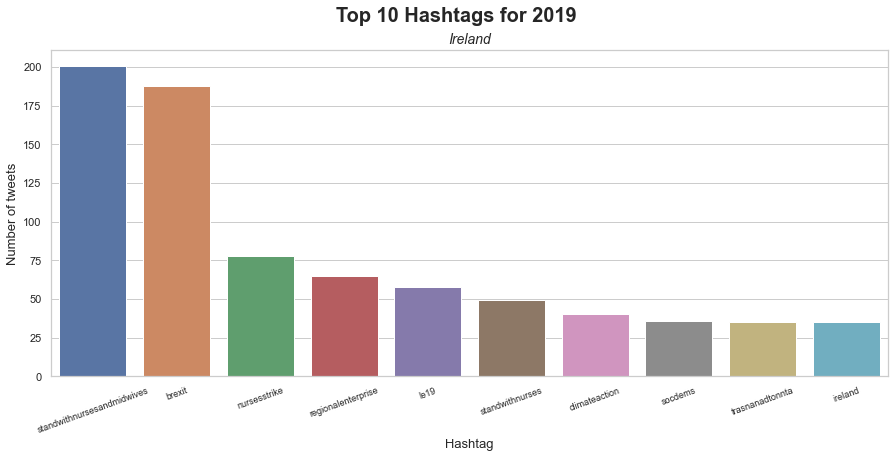

In [21]:
# Plot for 2019
bar_plots("index", "hashtag", top10_19, "Ireland", "Top 10 Hashtags for 2019", "Hashtag", "Number of tweets")

### Exercise 2. 

Who are the politicians that use 1 more hashtags in the time period around the elections? Consider the top 5 politicians in terms of hashtag use and plot their relative usage 2with daily level aggregation (focus only on the week before and after the election periods). Comment, do you see some interesting facts?

In [26]:
# We have to consider only self made tweets 
no_retweet_20 = df_20.loc[df_20["retweeted_user_id"].isna()]
print(no_retweet_20.shape)

(4337, 74)


In [27]:
# Data frame with the hashtags
a = pd.DataFrame(list(hash_retrieve(no_retweet_20)), columns=['hashtag', 'id'])
print(a.shape)

(3610, 2)


In [28]:
# Merging to get the hashtags with its respectively usernames
hashtags_users = pd.merge(a, 
                          no_retweet_20[["id", 'author.id', 'author.username', 'author.name', 'created_at']],
                          on='id',how='left')
hashtags_users.head()

,hashtag,id,author.id,author.username,author.name,created_at
0,GE2020,1228460983636709377,39472243,AlanFarrell,Alan Farrell TD,2020-02-14T23:28:16.000Z
1,justiceforcesupervisors,1228377556681920512,116422140,alankellylabour,Alan Kelly TD,2020-02-14T17:56:46.000Z
2,Cavan,1228371339515486208,430714461,BrendanSmithTD,Brendan Smith,2020-02-14T17:32:04.000Z
3,Monaghan,1228371339515486208,430714461,BrendanSmithTD,Brendan Smith,2020-02-14T17:32:04.000Z
4,NorthMeath,1228371339515486208,430714461,BrendanSmithTD,Brendan Smith,2020-02-14T17:32:04.000Z


In [29]:
# Convert dates to local time
date_time(hashtags_users,'created_at','no','Etc/GMT+1')
hashtags_users['date_new'] = hashtags_users['date_new'].dt.date # get only the date

# Print the new dataframe
print(hashtags_users.shape)
hashtags_users.head()

(3610, 7)


,hashtag,id,author.id,author.username,author.name,created_at,date_new
0,GE2020,1228460983636709377,39472243,AlanFarrell,Alan Farrell TD,2020-02-14 23:28:16,2020-02-14
1,justiceforcesupervisors,1228377556681920512,116422140,alankellylabour,Alan Kelly TD,2020-02-14 17:56:46,2020-02-14
2,Cavan,1228371339515486208,430714461,BrendanSmithTD,Brendan Smith,2020-02-14 17:32:04,2020-02-14
3,Monaghan,1228371339515486208,430714461,BrendanSmithTD,Brendan Smith,2020-02-14 17:32:04,2020-02-14
4,NorthMeath,1228371339515486208,430714461,BrendanSmithTD,Brendan Smith,2020-02-14 17:32:04,2020-02-14


In [30]:
# Top five of politicians that use more hashtags in the time period around the elections
tags_used_user = hashtags_users["author.name"].value_counts()[:5]
tags_used_user

Michael Healy-Rae      171
Josepha Madigan ⚖️✨    163
Billy Timmins          158
Niamh Smyth TD         147
Mick Barry TD          112
Name: author.name, dtype: int64

In [31]:
# Computing the total hashtags used per day
hashtags_day = hashtags_users["date_new"].value_counts().to_frame(name="hashtags_day").rename_axis('date_new').reset_index()
hashtags_day.head()

,date_new,hashtags_day
0,2020-02-07,478
1,2020-02-04,460
2,2020-02-06,440
3,2020-02-05,438
4,2020-02-08,420


In [79]:
# Getting the total hashtag per day of the top tags users and their relative frequency

# filter by the top 5 users 
hashtags_users_5 = hashtags_users[hashtags_users["author.name"].isin(tags_used_user.reset_index()["index"].to_list())]

# Counts per user per day
users_5_day = hashtags_users_5.groupby(["author.name", "date_new"]).size().to_frame(name="hashtags_produced").reset_index()

# Merging and computing the relative frequency
users_5_day = pd.merge(users_5_day, hashtags_day, on='date_new',how='left')
users_5_day["relative_usage"] = users_5_day["hashtags_produced"]/users_5_day["hashtags_day"]
users_5_day["date_new"] = pd.to_datetime(users_5_day["date_new"])

users_5_day.head()


,author.name,date_new,hashtags_produced,hashtags_day,relative_usage
0,Billy Timmins,2020-02-01,42,344,0.122093
1,Billy Timmins,2020-02-03,10,402,0.024876
2,Billy Timmins,2020-02-04,14,460,0.030435
3,Billy Timmins,2020-02-05,26,438,0.059361
4,Billy Timmins,2020-02-06,34,440,0.077273


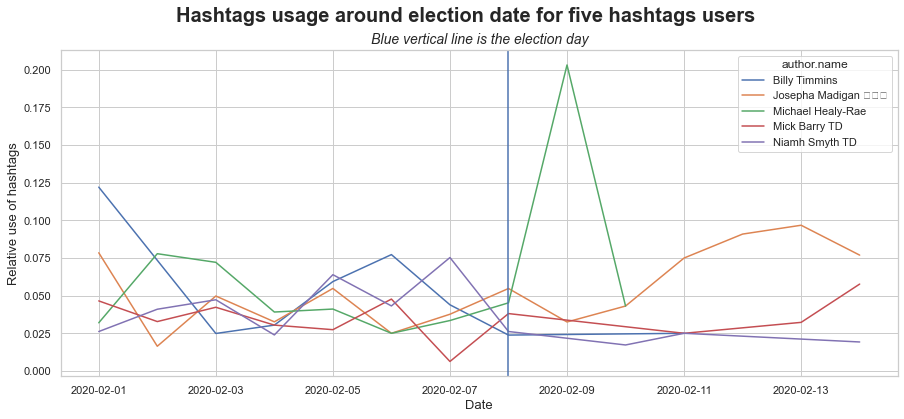

In [80]:
# Plot
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = "date_new", y = "relative_usage", data = users_5_day, hue="author.name")
plt.axvline(x=datetime.datetime(2020,2,8))

plt.title('Blue vertical line is the election day',fontsize=14, style="italic")
plt.suptitle("Hashtags usage around election date for five hashtags users", weight="bold").set_fontsize('20')
plt.xlabel("Date").set_fontsize('13')
plt.ylabel("Relative use of hashtags").set_fontsize('13')

#### Comment: 
...

### Exercise 3. 
Can you select the top used emojis in your data? Similarly, create a code that takes the tweets’ text as input and transforms it to a demojized text column. Importantly, emojis need to be converted to the text that matches your specific language.

In [112]:
# First define a function to extract the emojis using the emoji module
def extract_emojis(text):
  return ''.join(emj for emj in text if emj in emoji.UNICODE_EMOJI['en'])

In [113]:
# Top used emojis in the column text and create a new column 
df_20['emojis'] = pd.Series([extract_emojis(i) for i in df_20['text']])

In [114]:
# Creation of a demojized text column nad if there areno emojis transform them to NaN
df_20['demojized_text']= pd.Series([emoji.demojize(i) for i in df_20['emojis']]).replace(r'^\s*$', np.nan, regex=True)

In [120]:
emoji_df = df_20[['text', 'emojis', 'demojized_text']]
print(emoji_df.shape)
emoji_df.head()

(8464, 3)


,text,emojis,demojized_text
0,"Enjoyable night in Carrick-on-Shannon at Leitrim @IFAmedia dinner to pay tribute to Adrian Leddy’s 45 year contribution to Irish farming. Pictured with Pat Murphy, Chairman Connacht IFA. https://t.co/5UUdwvAgZG",,NaN
1,Last of the posters coming down across the constituency today. #GE2020 https://t.co/XwbAwcYzGI,,NaN
2,@Grahamiii Will retrieve Graham. A few stragglers left.. https://t.co/aP7QGTd83M,,NaN
3,So delighted to hear this - and more than happy to help 💪💪💪 https://t.co/7yxqKk625p,💪💪💪,:flexed_biceps::flexed_biceps::flexed_biceps:
4,"Enjoyable night in Carrick-on-Shannon at Leitrim @IFAmedia dinner to pay tribute to Adrian Leddy’s 45 year contribution to Irish farming. Pictured with Pat Murphy, Chairman Connacht IFA. https://t.co/5UUdwvAgZG",,NaN


In [131]:
# We will remove the NaNs
emoji_df.dropna(inplace=True)
print(emoji_df.shape)

# Create a dataframe with the emojis and its frequency
emoji_top = emoji_df['demojized_text']
emoji_top = sum([re.findall(':(.+?):', i) for i in emoji_top], [])
emoji_top = pd.DataFrame([(i,emoji_top.count(i)) for i in set(emoji_top)])
emoji_top.head()

# Create the dataframe with the top 10 by frequency
top_emojis = emoji_top.rename(columns={0: 'Emoji_demojized', 1:'Count'}).sort_values('Count', ascending = False)
top_emojisplot = top_emojis.head(10)
top_emojisplot['Emoji'] = [emoji.emojize(':'+i+':') for i in top_emojisplot['Emoji_demojized']]
top_emojisplot

(1344, 3)


,Emoji_demojized,Count,Emoji
265,check_mark_button,191,✅
228,ballot_box_with_ballot,178,🗳️
286,rose,156,🌹
56,green_heart,146,💚
264,check_mark,124,✔️
9,purple_heart,119,💜
270,clapping_hands,101,👏
26,face_with_tears_of_joy,76,😂
0,red_heart,73,❤️
167,thumbs_up,70,👍


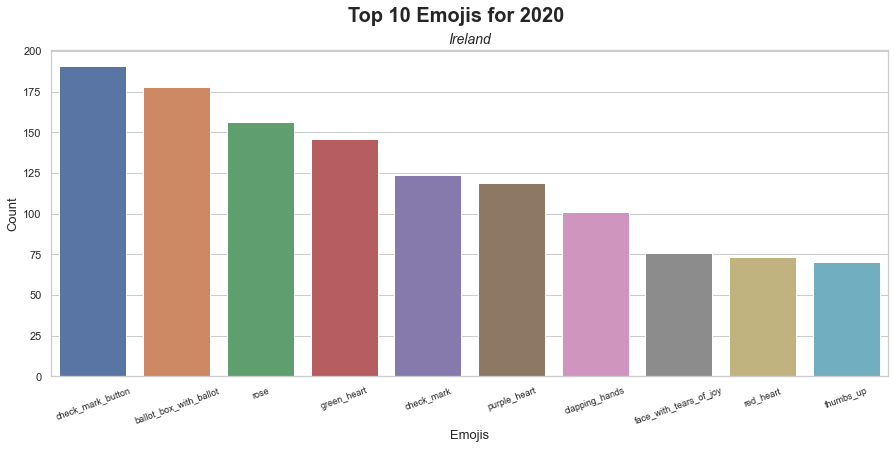

In [135]:
# Barplot for top emojis 
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 6))
ax = sns.barplot(x="Emoji_demojized", y="Count", data=top_emojisplot)
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation = 20, size=9)
plt.title('Ireland',fontsize=14, style="italic")
plt.suptitle("Top 10 Emojis for 2020", weight="bold").set_fontsize('20')
plt.xlabel("Emojis").set_fontsize('13')
plt.ylabel("Count").set_fontsize('13')

### Exercise 4. 
Repeat exercise 1 for the dataset that you obtained about Miami beach. What was going on in Miami those days?

In [18]:
# Download the data of Miami with the correct query
!twarc2 search --archive --start-time "2019-03-29" --end-time "2019-03-31" "point_radius:[-80.1709 25.7423 3.11mi]" files/miami.jsonl
!twarc2 csv files/miami.jsonl files/miami.csv

100%|██████████████| Processed 3.45M/3.45M of input file [00:01<00:00, 3.46MB/s]

ℹ️
Parsed 1436 tweets objects from 15 lines in the input file.
Wrote 1436 rows and output 74 columns in the CSV.



In [81]:
# Load the data into pandas df
miami_df = pd.read_csv("files/miami.csv")
miami_df[miami_df.columns[pd.Series(miami_df.columns).str.startswith('geo')]].head()

,geo.coordinates.coordinates,geo.coordinates.type,geo.country,geo.country_code,geo.full_name,geo.geo.bbox,geo.geo.type,geo.id,geo.name,geo.place_id,geo.place_type
0,"[-80.18541, 25.77161]",Point,Estados Unidos,US,"Miami, FL","[-80.321683, 25.7090404, -80.144974, 25.855667]",Feature,04cb31bae3b3af93,Miami,04cb31bae3b3af93,city
1,NaN,NaN,Estados Unidos,US,Marlins Park,"[-80.22144846000792, 25.778580385989454, -80.2...",Feature,07d9d339c4084000,Marlins Park,07d9d339c4084000,poi
2,"[-80.192, 25.7752]",Point,Estados Unidos,US,"Miami, FL","[-80.321683, 25.7090404, -80.144974, 25.855667]",Feature,04cb31bae3b3af93,Miami,04cb31bae3b3af93,city
3,"[-80.18997042, 25.7584841]",Point,Estados Unidos,US,"Miami, FL","[-80.321683, 25.7090404, -80.144974, 25.855667]",Feature,04cb31bae3b3af93,Miami,04cb31bae3b3af93,city
4,"[-80.16957, 25.7767103]",Point,Estados Unidos,US,"Florida, USA","[-87.634643, 24.396308, -79.974307, 31.001056]",Feature,4ec01c9dbc693497,Florida,4ec01c9dbc693497,admin


In [23]:
# Retrieve the hashtags using the function
hashtags_miami = pd.DataFrame(list(hash_retrieve(miami_df)), columns=['hashtag', 'id'])

In [12]:
# Top 10 hasgtags df
hashtags_miami["hashtag"] = hashtags_miami["hashtag"].str.lower() # Convert everything to lowercase 
top10_miami = hashtags_miami['hashtag'].value_counts()[:10].to_frame().reset_index()

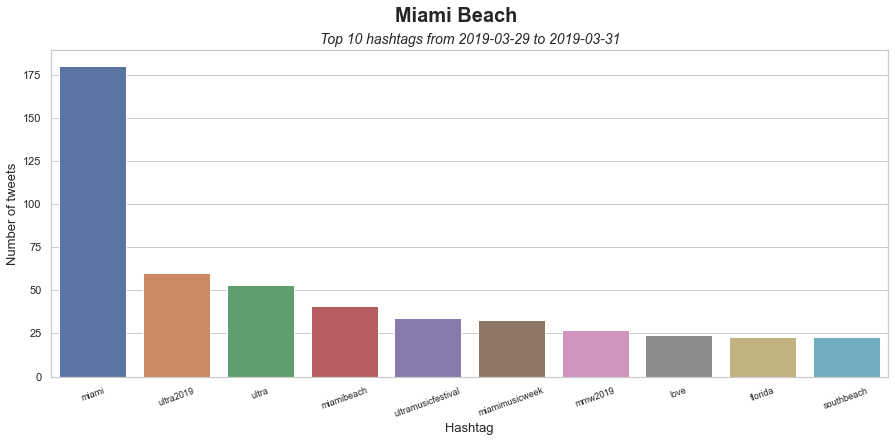

In [13]:
# Plot
bar_plots("index", "hashtag", top10_miami, "Top 10 hashtags from 2019-03-29 to 2019-03-31", "Miami Beach", "Hashtag", "Number of tweets")

### Exercise 5. 
Using Miami’s dataset, complete the following function (preferably using python) using python:

In [ ]:
def map_tweets (df , center_coords , filename ):
    """
    Goes from a tweet df and outputs the html map of the geoccordinates .
    df: Dataframe | of tweets that contain geolocation
    center_coords : list | [lat ,lng ] of the centered point of the map
    filename : str | name of the output file in html format
    """

In [142]:
# Function
def map_tweets(df , center_coords, filename):
    """
    Goes from a tweet df and outputs the html map of the geoccordinates .
    df: Dataframe | of tweets that contain geolocation
    center_coords : list | [lat ,lng ] of the centered point of the map
    filename : str | name of the output file in html format
    """
    df2 = df.copy() # Copying the data frame
    df2 = df2.dropna(axis = 0, subset = ["geo.coordinates.coordinates"]) # Drop the rows without coordinates

    latitud = df2["geo.coordinates.coordinates"].apply(lambda x: re.findall('-?\d+\.\d+', x)[1]) # Get latitud
    longitude = df2["geo.coordinates.coordinates"].apply(lambda x: re.findall('-?\d+\.\d+', x)[0]) # Get longitude

    # Print a map centered at Miami
    miami_map = folium.Map(location=center_coords, zoom_start=12)

    # Looping over each row (point) to add it in the map 
    for point in latitud.index:
        folium.CircleMarker(location=[latitud[point], longitude[point]], radius=2, color = 'red', fill_color = 'red').add_to(miami_map)
        
    miami_map.save(filename) # Save the map

    return miami_map

In [143]:
# Test
map_tweets(miami_df , [25.7423, -80.1709], 'files/miami_tweets_map.html')

## Extra exercises:

**Extra:** We have seen that only those tweets that attach a picture come with exact geolocation. Knowing this, can you create a python loop that extracts the URLS in those tweets and opens them in your browser. HINTS: There are several ways to do this but you can use regular expressions for the URLS and webbrowser to open them

In [102]:
# get the urls of the tweets
miami_df['url_media'] = miami_df['text'].str.extract(r'(https.*)')
miami_df['url_media'] # printing urls with location

0       https://t.co/pBXPHuJvQl
1       https://t.co/yZjGC2ezx4
2       https://t.co/wtY2jCd70b
3       https://t.co/G9ud2Zh2a4
4       https://t.co/ejITN4KwqH
                 ...           
1431    https://t.co/xBzO5zxK7S
1432    https://t.co/H3ucWhAxP0
1433    https://t.co/pNoFAuTgax
1434    https://t.co/4AUaNxQNWt
1435    https://t.co/WWhS6n1L3m
Name: url_media, Length: 1436, dtype: object

In [104]:
miami_df

,id,conversation_id,referenced_tweets.replied_to.id,referenced_tweets.retweeted.id,referenced_tweets.quoted.id,author_id,in_reply_to_user_id,retweeted_user_id,quoted_user_id,created_at,text,lang,source,public_metrics.like_count,public_metrics.quote_count,public_metrics.reply_count,public_metrics.retweet_count,reply_settings,possibly_sensitive,withheld.scope,withheld.copyright,withheld.country_codes,entities.annotations,entities.cashtags,entities.hashtags,entities.mentions,entities.urls,context_annotations,attachments.media,attachments.media_keys,attachments.poll.duration_minutes,attachments.poll.end_datetime,attachments.poll.id,attachments.poll.options,attachments.poll.voting_status,attachments.poll_ids,author.id,author.created_at,author.username,author.name,author.description,author.entities.description.cashtags,author.entities.description.hashtags,author.entities.description.mentions,author.entities.description.urls,author.entities.url.urls,author.location,author.pinned_tweet_id,author.profile_image_url,author.protected,author.public_metrics.followers_count,author.public_metrics.following_count,author.public_metrics.listed_count,author.public_metrics.tweet_count,author.url,author.verified,author.withheld.scope,author.withheld.copyright,author.withheld.country_codes,geo.coordinates.coordinates,geo.coordinates.type,geo.country,geo.country_code,geo.full_name,geo.geo.bbox,geo.geo.type,geo.id,geo.name,geo.place_id,geo.place_type,__twarc.retrieved_at,__twarc.url,__twarc.version,Unnamed: 73,url_media
0,1112142450313908224,1112142450313908224,NaN,NaN,NaN,23548059,NaN,NaN,NaN,2019-03-30T23:59:57.000Z,Let the birthday festivities continue! @ Il Gabbiano https://t.co/pBXPHuJvQl,en,Instagram,0,0,0,0,everyone,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""start"": 53, ""end"": 76, ""url"": ""https://t.co/pBXPHuJvQl"", ""expanded_url"": ""https://www.instagram.com/p/BvptsaZgAan/?utm_source=ig_twitter_share&igshid=1h4fz2a4j9ygi"", ""display_url"": ""instagram.com/p/BvptsaZgAan/\u2026""}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23548059,2009-03-10T03:01:37.000Z,davidrubinoff,David Rubinoff,Canes fan. Wine drinker. Bike rider. It ain't no sin to be glad you're alive!,NaN,NaN,NaN,NaN,NaN,Boca Raton,NaN,https://pbs.twimg.com/profile_images/789849085700370432/sEQ3QDVV_normal.jpg,False,371,1042,8,9352,NaN,False,NaN,NaN,NaN,"[-80.18541, 25.77161]",Point,Estados Unidos,US,"Miami, FL","[-80.321683, 25.7090404, -80.144974, 25.855667]",Feature,04cb31bae3b3af93,Miami,04cb31bae3b3af93,city,2022-01-18T14:01:32+00:00,https://api.twitter.com/2/tweets/search/all?expansions=author_id%2Cin_reply_to_user_id%2Creferenced_tweets.id%2Creferenced_tweets.id.author_id%2Centities.mentions.username%2Cattachments.poll_ids%2Cattachments.media_keys%2Cgeo.place_id&tweet.fields=attachments%2Cauthor_id%2Cco...,2.8.3,NaN,https://t.co/pBXPHuJvQl
1,1112142361734402049,1112142361734402049,NaN,NaN,NaN,700139828,NaN,NaN,NaN,2019-03-30T23:59:36.000Z,Lo poncharon! #JuntosMiami @Marlins https://t.co/yZjGC2ezx4,es,Twitter for Android,1,0,0,0,everyone,False,NaN,NaN,NaN,NaN,NaN,"[{""start"": 14, ""end"": 26, ""tag"": ""JuntosMiami""}]","[{""start"": 28, ""end"": 36, ""username"": ""Marlins"", ""id"": ""52863923"", ""description"": ""Official Twitter account of the Miami Marlins. We have a roof: @loanDepotpark #JuntosMiami"", ""public_metrics"": {""followers_count"": 378525, ""following_count"": 847, ""tweet_count"": 81620, ""listed_...","[{""start"": 37, ""end"": 60, ""url"": ""https://t.co/yZjGC2ezx4"", ""expanded_url"": ""https://twitter.com/mirtlesays/status/1112142361734402049/photo/1"", ""display_url"": ""pic.twitter.com/yZjGC2ezx4""}]","[{""domain"": {""id"": ""3"", ""name"": ""TV Shows"", ""description"": ""Television shows from around the world""}, ""entity"": {""id"": ""10001466882"", ""name"": ""MLB Baseball"", ""description"": ""All the latest action from Major League Baseball.""}}, {""domain"": {""id"": ""3"", ""name"": ""TV Shows"", ""desc...","[{""height"": 1152, ""url"": ""https:/

In [105]:
miami_df['source'].value_counts()

Instagram                 1130
Twitter for iPhone         177
Twitter for Android         50
Foursquare                  32
TTN MIA traffic             15
Tweetbot for iΟS            14
TownTweet                    4
Hootsuite Inc.               3
CORE ListingMachine          2
Foursquare Swarm             2
dlvr.it                      2
Untappd                      2
Flamingo for Android         1
UberSocial for Android       1
Cities                       1
Name: source, dtype: int64